In [1]:
import os
import openpyxl

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import statsmodels.api as sm

from glob import glob
from math import ceil, floor
from pathlib import Path


from utility import mean_absolute_percentage_error, calibrate_branch_trait, calibrate_branch_trait_from_other_excel, simple_regplot, plot_linear_fit, plot_best_ransac_fit, evaluation

In [4]:
field_measurement_filepath = Path(r"D:\Data\Apple_Orchard\Lailiang_Cheng\Field_Measurements.xlsx")

data_folder = Path(r'D:\Code\Apple_Crop_Potential_Prediction\data\row13\characterization')
exp_id =  'multiplier_by_3_cpc_sphere_radius_002'
exp_ref_id = 'multiplier_by_3'
data_folder = data_folder / exp_id
excel_files = sorted(glob(str(data_folder / 'tree*_branch_*.xlsx')))
print(excel_files)

save_folder = data_folder
save_folder.mkdir(exist_ok=True)

['D:\\Code\\Apple_Crop_Potential_Prediction\\data\\row13\\characterization\\multiplier_by_3_cpc_sphere_radius_002\\tree1_branch_test.xlsx', 'D:\\Code\\Apple_Crop_Potential_Prediction\\data\\row13\\characterization\\multiplier_by_3_cpc_sphere_radius_002\\tree2_branch_test.xlsx', 'D:\\Code\\Apple_Crop_Potential_Prediction\\data\\row13\\characterization\\multiplier_by_3_cpc_sphere_radius_002\\tree3_branch_test.xlsx', 'D:\\Code\\Apple_Crop_Potential_Prediction\\data\\row13\\characterization\\multiplier_by_3_cpc_sphere_radius_002\\tree4_branch_test.xlsx', 'D:\\Code\\Apple_Crop_Potential_Prediction\\data\\row13\\characterization\\multiplier_by_3_cpc_sphere_radius_002\\tree5_branch_test.xlsx', 'D:\\Code\\Apple_Crop_Potential_Prediction\\data\\row13\\characterization\\multiplier_by_3_cpc_sphere_radius_002\\tree6_branch_test.xlsx', 'D:\\Code\\Apple_Crop_Potential_Prediction\\data\\row13\\characterization\\multiplier_by_3_cpc_sphere_radius_002\\tree7_branch_test.xlsx', 'D:\\Code\\Apple_Crop_Pote

In [7]:
all_tree_df = None
all_sensor_measurement = 0
all_field_measurement = 0

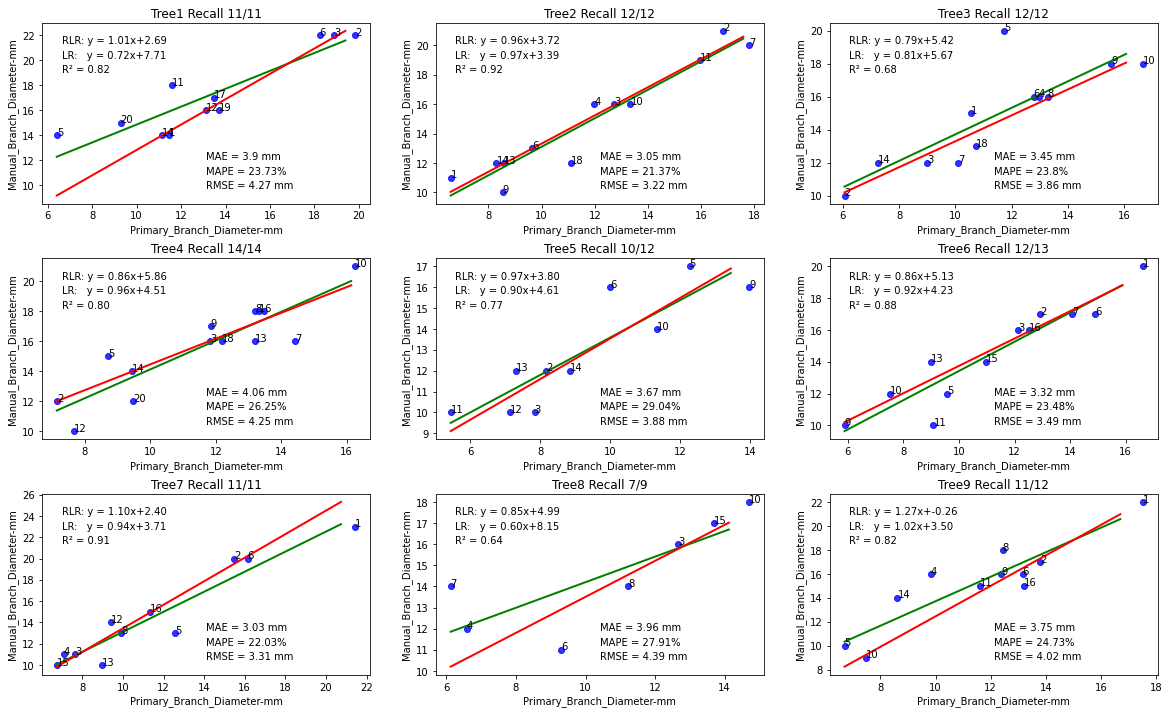

In [8]:
x_axis = 'Primary_Branch_Diameter-mm' # 'Manual_Vertical_Crotch_Angle-Degree'
y_axis = 'Manual_Branch_Diameter-mm'  # 'Vertical_Croth_Angle-Degree'

nrows = 3
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 12))
plt.subplots_adjust(wspace=None, hspace=0.3)


for index, characterization_filepath in enumerate(excel_files[:-1]):

    row = index // ncols
    col = index % ncols
    ax = axs[row, col]

    tree_id = Path(characterization_filepath).stem
    tree_id = tree_id.split('_')[0]

    field_measurement_df = pd.read_excel(field_measurement_filepath, sheet_name=tree_id.capitalize())

    characterization_excel = openpyxl.load_workbook(str(characterization_filepath))
    ref_characterization_filepath = Path(characterization_filepath).parents[1] / exp_ref_id / os.path.basename(characterization_filepath)
    ref_sensor_measurement_excel = openpyxl.load_workbook(str(ref_characterization_filepath))
    calibrated_sensor_measurement_gt = None

    sheetname = characterization_excel.sheetnames[0]
    sensor_measurement_df = pd.read_excel(str(characterization_filepath), sheet_name=sheetname)
    ref_sensor_measurement_df = pd.read_excel(str(ref_characterization_filepath), sheet_name=sheetname)
    
    calibrated_sensor_measurement_df = calibrate_branch_trait_from_other_excel(ref_sensor_measurement_df, field_measurement_df)

    sensor_measurement_df_reset = sensor_measurement_df.set_index('Branch ID')
    calibrated_sensor_measurement_df_reset = calibrated_sensor_measurement_df.set_index('Branch ID')
    sensor_measurement_df_reset[['Manual_Vertical_Crotch_Angle-Degree', 'Manual_Branch_Diameter-mm']] = calibrated_sensor_measurement_df_reset[['Manual_Vertical_Crotch_Angle-Degree', 'Manual_Branch_Diameter-mm']]

    tmp = sensor_measurement_df_reset.loc[~sensor_measurement_df_reset[y_axis].isnull(), :]
    valid_sensor_measurement_df = tmp.copy()
    valid_sensor_measurement_df['Primary_Branch_Diameter-mm'] = valid_sensor_measurement_df['Primary_Branch_Radius-mm'] * 2
    total_sensor_measurement = len(valid_sensor_measurement_df)
    total_field_measurement = len(field_measurement_df) - 1

    if all_tree_df is None:
        all_tree_df = valid_sensor_measurement_df
    else:
        all_tree_df = pd.concat([all_tree_df, valid_sensor_measurement_df])

    all_sensor_measurement = all_sensor_measurement + total_sensor_measurement
    all_field_measurement = all_field_measurement + total_field_measurement

    metrics = evaluation(valid_sensor_measurement_df, x=x_axis, y=y_axis)
    lr_x, lr_y, lr_coef, lr_intercept, lr_score = metrics['LR']
    ransac_lr_x, ransac_lr_y, rlr_coef, rlr_intercept, rlr_score = metrics['RLR']
    sns.regplot(x=x_axis, y=y_axis, data=valid_sensor_measurement_df, ci=None, fit_reg=False, robust=False, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, ax=ax)
    ax.plot(lr_x, lr_y, color="green", linewidth=2, label="Linear regressor")
    ax.plot(ransac_lr_x, ransac_lr_y, color="red", linewidth=2, label="RANSAC regressor")
    
    for row in valid_sensor_measurement_df.iterrows():
        tmp_est = row[1][x_axis]
        tmp_gt = row[1][y_axis]
        ax.text(tmp_est, tmp_gt, row[0])

    ax.text(0.06, 0.9, f'RLR: y = {rlr_coef[0][0]:.2f}x+{rlr_intercept[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.06, 0.82, f'LR:   y = {lr_coef[0][0]:.2f}x+{lr_intercept[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.06, 0.74, f'R\u00b2 = {lr_score:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)    
    ax.text(0.5, 0.26, f"MAE = {metrics['MAE']} mm", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.5, 0.18, f"MAPE = {metrics['MAPE']}%", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.5, 0.1, f"RMSE = {metrics['RMSE']} mm", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.set_title(f'{tree_id.capitalize()} Recall {total_sensor_measurement}/{total_field_measurement}')

# plt.savefig(str(save_folder / 'Diameter.png'), dpi=300)

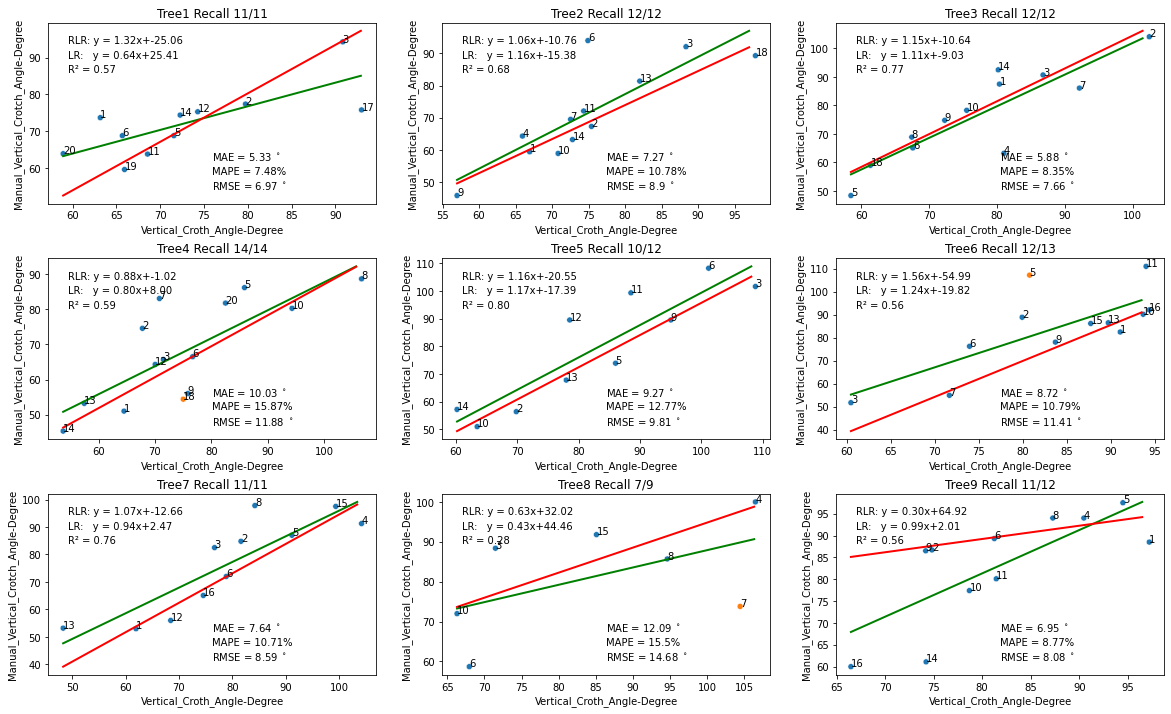

In [51]:
x_axis = 'Vertical_Croth_Angle-Degree'
y_axis = 'Manual_Vertical_Crotch_Angle-Degree'

nrows = 3
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 12))
plt.subplots_adjust(wspace=None, hspace=0.3)


for index, characterization_filepath in enumerate(excel_files[:-1]):

    row = index // ncols
    col = index % ncols
    ax = axs[row, col]

    tree_id = Path(characterization_filepath).stem
    tree_id = tree_id.split('_')[0]

    field_measurement_df = pd.read_excel(field_measurement_filepath, sheet_name=tree_id.capitalize())

    characterization_excel = openpyxl.load_workbook(str(characterization_filepath))
    ref_characterization_filepath = Path(characterization_filepath).parents[1] / exp_ref_id / os.path.basename(characterization_filepath)
    ref_sensor_measurement_excel = openpyxl.load_workbook(str(ref_characterization_filepath))
    calibrated_sensor_measurement_gt = None

    sheetname = characterization_excel.sheetnames[0]
    sensor_measurement_df = pd.read_excel(str(characterization_filepath), sheet_name=sheetname)
    ref_sensor_measurement_df = pd.read_excel(str(ref_characterization_filepath), sheet_name=sheetname)
    
    calibrated_sensor_measurement_df = calibrate_branch_trait_from_other_excel(ref_sensor_measurement_df, field_measurement_df)

    sensor_measurement_df_reset = sensor_measurement_df.set_index('Branch ID')
    calibrated_sensor_measurement_df_reset = calibrated_sensor_measurement_df.set_index('Branch ID')
    sensor_measurement_df_reset[['Manual_Vertical_Crotch_Angle-Degree', 'Manual_Branch_Diameter-mm']] = calibrated_sensor_measurement_df_reset[['Manual_Vertical_Crotch_Angle-Degree', 'Manual_Branch_Diameter-mm']]

    tmp = sensor_measurement_df_reset.loc[~sensor_measurement_df_reset['Manual_Branch_Diameter-mm'].isnull(), :]
    valid_sensor_measurement_df = tmp.copy()
    valid_sensor_measurement_df['Primary_Branch_Diameter-mm'] = valid_sensor_measurement_df['Primary_Branch_Radius-mm'] * 2
    total_sensor_measurement = len(valid_sensor_measurement_df)
    total_field_measurement = len(field_measurement_df) - 1

    # highlight angle error > 20 degree data points
    valid_sensor_measurement_df['Outlier'] = 0
    valid_sensor_measurement_df.loc[abs(valid_sensor_measurement_df[x_axis]-valid_sensor_measurement_df[y_axis]) > 20, 'Outlier'] = 1

    metrics = evaluation(valid_sensor_measurement_df, x=x_axis, y=y_axis)
    lr_x, lr_y, lr_coef, lr_intercept, lr_score = metrics['LR']
    ransac_lr_x, ransac_lr_y, rlr_coef, rlr_intercept, rlr_score = metrics['RLR']
    sns.regplot(x=x_axis, y=y_axis, data=valid_sensor_measurement_df, scatter=False, ci=None, fit_reg=False, robust=False, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, ax=ax)
    sns.scatterplot(x=x_axis, y=y_axis, data=valid_sensor_measurement_df, hue='Outlier', legend=False, ax=ax)
    ax.plot(lr_x, lr_y, color="green", linewidth=2, label="Linear regressor")
    ax.plot(ransac_lr_x, ransac_lr_y, color="red", linewidth=2, label="RANSAC regressor")

    for row in valid_sensor_measurement_df.iterrows():
        tmp_est = row[1][x_axis]
        tmp_gt = row[1][y_axis]
        ax.text(tmp_est, tmp_gt, row[0])

    ax.text(0.06, 0.9, f'RLR: y = {rlr_coef[0][0]:.2f}x+{rlr_intercept[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.06, 0.82, f'LR:   y = {lr_coef[0][0]:.2f}x+{lr_intercept[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.06, 0.74, f'R\u00b2 = {lr_score:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)    
    ax.text(0.5, 0.26, f"MAE = {metrics['MAE']} $^\circ$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.5, 0.18, f"MAPE = {metrics['MAPE']}%", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.5, 0.1, f"RMSE = {metrics['RMSE']} $^\circ$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.set_title(f'{tree_id.capitalize()} Recall {total_sensor_measurement}/{total_field_measurement}')

plt.savefig(str(save_folder / 'Angle.png'), dpi=300)

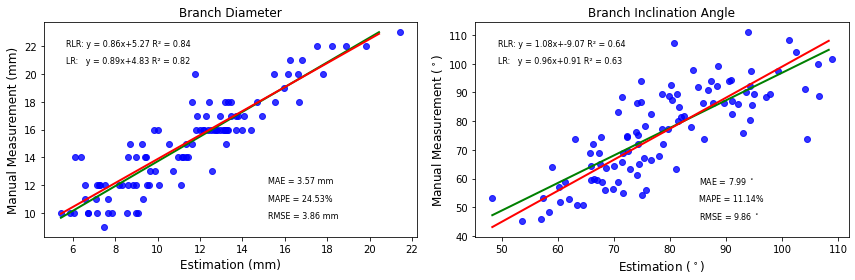

In [10]:
text_in_title_para = {'fontfamily': 'sans-serif', 'fontsize': 12, 'fontweight': 20}
text_in_figure_para = {'fontfamily': 'sans-serif', 'fontsize': 8, 'fontweight': 20, 'horizontalalignment': 'left', 'verticalalignment': 'center'}
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax = axes[0]
x_axis = 'Primary_Branch_Diameter-mm' # 'Manual_Vertical_Crotch_Angle-Degree'
y_axis = 'Manual_Branch_Diameter-mm'  # 'Vertical_Croth_Angle-Degree'
metrics = evaluation(all_tree_df, x=x_axis, y=y_axis)
lr_x, lr_y, lr_coef, lr_intercept, lr_score = metrics['LR']
ransac_lr_x, ransac_lr_y, rlr_coef, rlr_intercept, rlr_score = metrics['RLR']
sns.regplot(x=x_axis, y=y_axis, data=all_tree_df, ci=None, fit_reg=False, robust=False, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, ax=ax)
ax.plot(lr_x, lr_y, color="green", linewidth=2, label="Linear regressor")
ax.plot(ransac_lr_x, ransac_lr_y, color="red", linewidth=2, label="RANSAC regressor")
ax.text(0.06, 0.9, f'RLR: y = {rlr_coef[0][0]:.2f}x+{rlr_intercept[0]:.2f} R\u00b2 = 0.84', **text_in_figure_para, transform=ax.transAxes)
ax.text(0.06, 0.82, f'LR:   y = {lr_coef[0][0]:.2f}x+{lr_intercept[0]:.2f} R\u00b2 = {lr_score:.2f}', **text_in_figure_para, transform=ax.transAxes)
ax.text(0.6, 0.26, f"MAE = {metrics['MAE']} mm", **text_in_figure_para, transform=ax.transAxes)
ax.text(0.6, 0.18, f"MAPE = {metrics['MAPE']}%", **text_in_figure_para, transform=ax.transAxes)
ax.text(0.6, 0.1, f"RMSE = {metrics['RMSE']} mm", **text_in_figure_para, transform=ax.transAxes)
ax.set_title('Branch Diameter', **text_in_title_para)
ax.set_xlabel('Estimation (mm)', **text_in_title_para)
ax.set_ylabel('Manual Measurement (mm)', **text_in_title_para)

ax = axes[1]
x_axis = 'Vertical_Croth_Angle-Degree'
y_axis = 'Manual_Vertical_Crotch_Angle-Degree'
metrics = evaluation(all_tree_df, x=x_axis, y=y_axis)
lr_x, lr_y, lr_coef, lr_intercept, lr_score = metrics['LR']
ransac_lr_x, ransac_lr_y, rlr_coef, rlr_intercept, rlr_score = metrics['RLR']
sns.regplot(x=x_axis, y=y_axis, data=all_tree_df, ci=None, fit_reg=False, robust=False, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, ax=ax)
ax.plot(lr_x, lr_y, color="green", linewidth=2, label="Linear regressor")
ax.plot(ransac_lr_x, ransac_lr_y, color="red", linewidth=2, label="RANSAC regressor")
ax.text(0.06, 0.9, f'RLR: y = {rlr_coef[0][0]:.2f}x+{rlr_intercept[0]:.2f} R\u00b2 = 0.64', **text_in_figure_para, transform=ax.transAxes)
ax.text(0.06, 0.82, f'LR:   y = {lr_coef[0][0]:.2f}x+{lr_intercept[0]:.2f} R\u00b2 = {lr_score:.2f}', **text_in_figure_para, transform=ax.transAxes)
ax.text(0.6, 0.26, f"MAE = {metrics['MAE']} $^\circ$", **text_in_figure_para, transform=ax.transAxes)
ax.text(0.6, 0.18, f"MAPE = {metrics['MAPE']}%", **text_in_figure_para, transform=ax.transAxes)
ax.text(0.6, 0.1, f"RMSE = {metrics['RMSE']} $^\circ$", **text_in_figure_para, transform=ax.transAxes)
ax.set_title('Branch Inclination Angle', **text_in_title_para)
ax.set_xlabel('Estimation ($^\circ$)', **text_in_title_para)
ax.set_ylabel('Manual Measurement ($^\circ$)', **text_in_title_para)

fig.tight_layout()

# fig.suptitle(f'9 Trees Recall {all_sensor_measurement}/{all_field_measurement}')
plt.savefig(str(save_folder / 'branch_trait_evaluation.png'), dpi=300)

In [53]:
all_tree_df.to_csv(str(save_folder / 'all_tree.csv'))

C:\Users\tq42\AppData\Local\Temp\ipykernel_26104\2276310564.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Text(0.5, 0.98, 'Treea Recall 18/20')

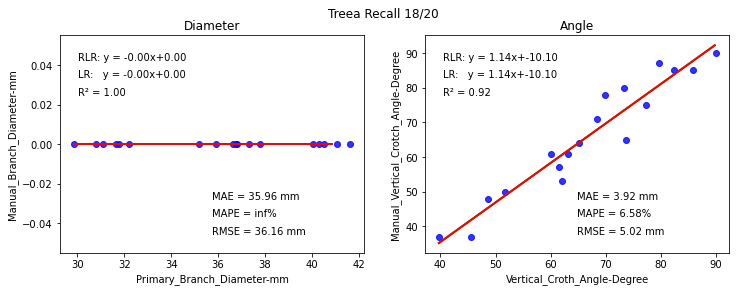

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

characterization_filepath = excel_files[-1]

tree_id = Path(characterization_filepath).stem
tree_id = tree_id.split('_')[0]

field_measurement_df = pd.read_excel(field_measurement_filepath, sheet_name=tree_id[:1].upper()+tree_id[1:])

characterization_excel = openpyxl.load_workbook(str(characterization_filepath))
calibrated_sensor_measurement_gt = None

sheetname = characterization_excel.sheetnames[0]
sensor_measurement_df = pd.read_excel(str(characterization_filepath), sheet_name=sheetname)
calibrated_sensor_measurement_df = calibrate_branch_trait_from_other_excel(sensor_measurement_df, field_measurement_df)

sensor_measurement_df_reset = sensor_measurement_df.set_index('Branch ID')
calibrated_sensor_measurement_df_reset = calibrated_sensor_measurement_df.set_index('Branch ID')
sensor_measurement_df_reset[['Manual_Vertical_Crotch_Angle-Degree', 'Manual_Branch_Diameter-mm']] = calibrated_sensor_measurement_df_reset[['Manual_Vertical_Crotch_Angle-Degree', 'Manual_Branch_Diameter-mm']]

tmp = sensor_measurement_df_reset.loc[~sensor_measurement_df_reset['Manual_Branch_Diameter-mm'].isnull(), :]
valid_sensor_measurement_df = tmp.copy()
valid_sensor_measurement_df['Primary_Branch_Diameter-mm'] = valid_sensor_measurement_df['Primary_Branch_Radius-mm'] * 2
total_sensor_measurement = len(valid_sensor_measurement_df)
total_field_measurement = len(field_measurement_df) - 1

ax = axes[0]
x_axis = 'Primary_Branch_Diameter-mm' # 'Manual_Vertical_Crotch_Angle-Degree'
y_axis = 'Manual_Branch_Diameter-mm'  # 'Vertical_Croth_Angle-Degree'
metrics = evaluation(valid_sensor_measurement_df, x=x_axis, y=y_axis)
lr_x, lr_y, lr_coef, lr_intercept, lr_score = metrics['LR']
ransac_lr_x, ransac_lr_y, rlr_coef, rlr_intercept, rlr_score = metrics['RLR']
sns.regplot(x=x_axis, y=y_axis, data=valid_sensor_measurement_df, ci=None, fit_reg=False, robust=False, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, ax=ax)
ax.plot(lr_x, lr_y, color="green", linewidth=2, label="Linear regressor")
ax.plot(ransac_lr_x, ransac_lr_y, color="red", linewidth=2, label="RANSAC regressor")
ax.text(0.06, 0.9, f'RLR: y = {rlr_coef[0][0]:.2f}x+{rlr_intercept[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.06, 0.82, f'LR:   y = {lr_coef[0][0]:.2f}x+{lr_intercept[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.06, 0.74, f'R\u00b2 = {lr_score:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)    
ax.text(0.5, 0.26, f"MAE = {metrics['MAE']} mm", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.5, 0.18, f"MAPE = {metrics['MAPE']}%", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.5, 0.1, f"RMSE = {metrics['RMSE']} mm", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.set_title('Diameter')

ax = axes[1]
x_axis = 'Vertical_Croth_Angle-Degree'
y_axis = 'Manual_Vertical_Crotch_Angle-Degree'
metrics = evaluation(valid_sensor_measurement_df, x=x_axis, y=y_axis)
lr_x, lr_y, lr_coef, lr_intercept, lr_score = metrics['LR']
ransac_lr_x, ransac_lr_y, rlr_coef, rlr_intercept, rlr_score = metrics['RLR']
sns.regplot(x=x_axis, y=y_axis, data=valid_sensor_measurement_df, ci=None, fit_reg=False, robust=False, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, ax=ax)
ax.plot(lr_x, lr_y, color="green", linewidth=2, label="Linear regressor")
ax.plot(ransac_lr_x, ransac_lr_y, color="red", linewidth=2, label="RANSAC regressor")
ax.text(0.06, 0.9, f'RLR: y = {rlr_coef[0][0]:.2f}x+{rlr_intercept[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.06, 0.82, f'LR:   y = {lr_coef[0][0]:.2f}x+{lr_intercept[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.06, 0.74, f'R\u00b2 = {lr_score:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)    
ax.text(0.5, 0.26, f"MAE = {metrics['MAE']} mm", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.5, 0.18, f"MAPE = {metrics['MAPE']}%", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.5, 0.1, f"RMSE = {metrics['RMSE']} mm", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.set_title('Angle')

fig.suptitle(f'{tree_id.capitalize()} Recall {total_sensor_measurement}/{total_field_measurement}')
# plt.savefig(str(save_folder / tree_id.capitalize()))

In [19]:
valid_sensor_measurement_df

,Filename,Vertical_Croth_Angle-Degree,Primary_Branch_Radius-mm,Label,Manual_Vertical_Crotch_Angle-Degree,Manual_Branch_Diameter-mm,Primary_Branch_Diameter-mm
Branch ID,,,,,,,
1,tree4,60.90,7.52,Section1_Blue,51.0,18.0,15.04
2,tree4,69.39,3.56,Section1_Green,74.6,12.0,7.12
3,tree4,70.23,5.92,Section1_Orange,65.7,16.0,11.84
5,tree4,86.08,4.39,Section1_Black,86.2,15.0,8.78
6,tree4,88.82,8.44,Section2_Orange,66.5,18.0,16.88
7,tree4,69.98,7.73,Section2_Green,83.1,16.0,15.46
8,tree4,80.91,7.54,Section2_Blue,88.7,18.0,15.08
9,tree4,74.32,6.56,Section2_Black,56.0,17.0,13.12
10,tree4,87.61,8.70,Section3_Blue,80.3,21.0,17.40


In [11]:
valid_sensor_measurement_df.index

Int64Index([1, 2, 4, 5, 6, 8, 9, 10, 11, 14, 16], dtype='int64', name='Branch ID')

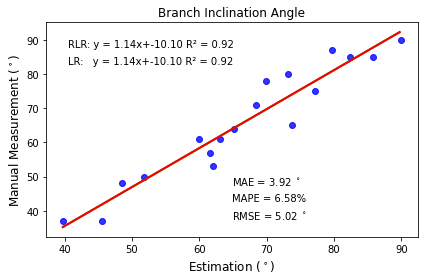

In [8]:
text_in_title_para = {'fontfamily': 'sans-serif', 'fontsize': 12, 'fontweight': 20}
text_in_figure_para = {'fontfamily': 'sans-serif', 'fontsize': 8, 'fontweight': 20, 'horizontalalignment': 'left', 'verticalalignment': 'center'}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

characterization_filepath = excel_files[-1]

tree_id = Path(characterization_filepath).stem
tree_id = tree_id.split('_')[0]

field_measurement_df = pd.read_excel(field_measurement_filepath, sheet_name=tree_id[:1].upper()+tree_id[1:])

characterization_excel = openpyxl.load_workbook(str(characterization_filepath))
calibrated_sensor_measurement_gt = None

sheetname = characterization_excel.sheetnames[0]
sensor_measurement_df = pd.read_excel(str(characterization_filepath), sheet_name=sheetname)
calibrated_sensor_measurement_df = calibrate_branch_trait_from_other_excel(sensor_measurement_df, field_measurement_df)

sensor_measurement_df_reset = sensor_measurement_df.set_index('Branch ID')
calibrated_sensor_measurement_df_reset = calibrated_sensor_measurement_df.set_index('Branch ID')
sensor_measurement_df_reset[['Manual_Vertical_Crotch_Angle-Degree', 'Manual_Branch_Diameter-mm']] = calibrated_sensor_measurement_df_reset[['Manual_Vertical_Crotch_Angle-Degree', 'Manual_Branch_Diameter-mm']]

tmp = sensor_measurement_df_reset.loc[~sensor_measurement_df_reset['Manual_Branch_Diameter-mm'].isnull(), :]
valid_sensor_measurement_df = tmp.copy()
valid_sensor_measurement_df['Primary_Branch_Diameter-mm'] = valid_sensor_measurement_df['Primary_Branch_Radius-mm'] * 2
total_sensor_measurement = len(valid_sensor_measurement_df)
total_field_measurement = len(field_measurement_df) - 1


x_axis = 'Vertical_Croth_Angle-Degree'
y_axis = 'Manual_Vertical_Crotch_Angle-Degree'
metrics = evaluation(valid_sensor_measurement_df, x=x_axis, y=y_axis)
lr_x, lr_y, lr_coef, lr_intercept, lr_score = metrics['LR']
ransac_lr_x, ransac_lr_y, rlr_coef, rlr_intercept, rlr_score = metrics['RLR']
sns.regplot(x=x_axis, y=y_axis, data=valid_sensor_measurement_df, ci=None, fit_reg=False, robust=False, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, ax=ax)
ax.plot(lr_x, lr_y, color="green", linewidth=2, label="Linear regressor")
ax.plot(ransac_lr_x, ransac_lr_y, color="red", linewidth=2, label="RANSAC regressor")
ax.text(0.06, 0.9, f'RLR: y = {rlr_coef[0][0]:.2f}x+{rlr_intercept[0]:.2f} R\u00b2 = {lr_score:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.06, 0.82, f'LR:   y = {lr_coef[0][0]:.2f}x+{lr_intercept[0]:.2f} R\u00b2 = {lr_score:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.5, 0.26, f"MAE = {metrics['MAE']} $^\circ$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.5, 0.18, f"MAPE = {metrics['MAPE']}%", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.5, 0.1, f"RMSE = {metrics['RMSE']} $^\circ$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.set_title('Branch Inclination Angle', **text_in_title_para)
ax.set_xlabel('Estimation ($^\circ$)', **text_in_title_para)
ax.set_ylabel('Manual Measurement ($^\circ$)', **text_in_title_para)

fig.tight_layout()

plt.savefig(str(save_folder / tree_id.capitalize()))

In [7]:
save_folder

WindowsPath('D:/Code/Apple_Crop_Potential_Prediction/data/characterization/baseline')